# DNA Nanodevice GNN Demo
This demo will show how to use the G3NAT (Graph Neural Network Nucleic Acid Transport) package to create a DNA Nanodevice as a graph and use it to train a graph neural network (GNN) 

In [1]:
# Pytorch moduels
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch

#G3NAT Modules
from dataset import sequence_to_graph
from models import DNATransportGNN, train_model
from data_generator import create_sample_data, getTransmissionDOS
from visualize_dna_graph import visualize_dna_graph

# Other Python modules
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Graph generation
Let's start with a test case: Double stranded DNA with two tails connected to contacts

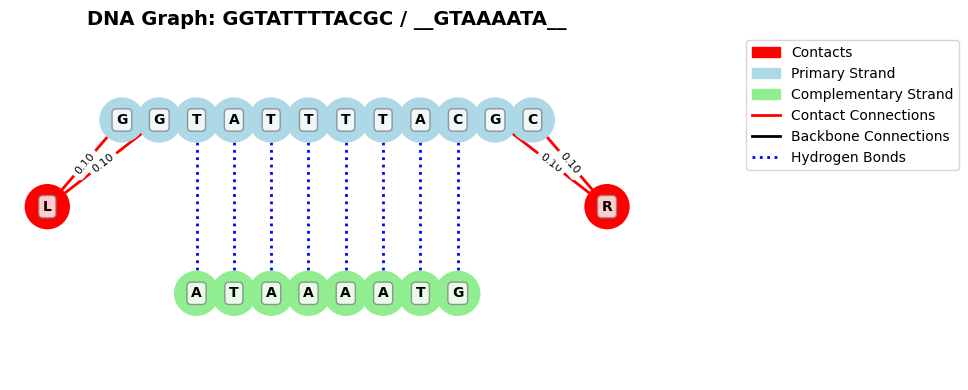

Data(x=[22, 4], edge_index=[2, 60], edge_attr=[60, 5], num_dna_nodes=20)


In [10]:
sequence = "GGTATTTTACGC"
complement = "__GTAAAATA__"
contVal=0.1
lCont = [0,1]
rCont = [len(sequence)-2, len(sequence)-1]
    
# Simple case: left contact at first position, right contact at last position
graph = sequence_to_graph(
    sequence,
    complement,
    left_contact_positions=lCont,  # Connect to first bases (AC)
    right_contact_positions=rCont,  # Connect to last bases (GT)
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)
fig, ax = visualize_dna_graph(graph, sequence, complement, figsize=(10,4))
plt.show()
print(graph)

Now we can use the built in functions to generate density of states (DOS) and coherent transmission with from the tight-binding model

Text(0.5, 0, '$E-E_{HOMO}$ eV')

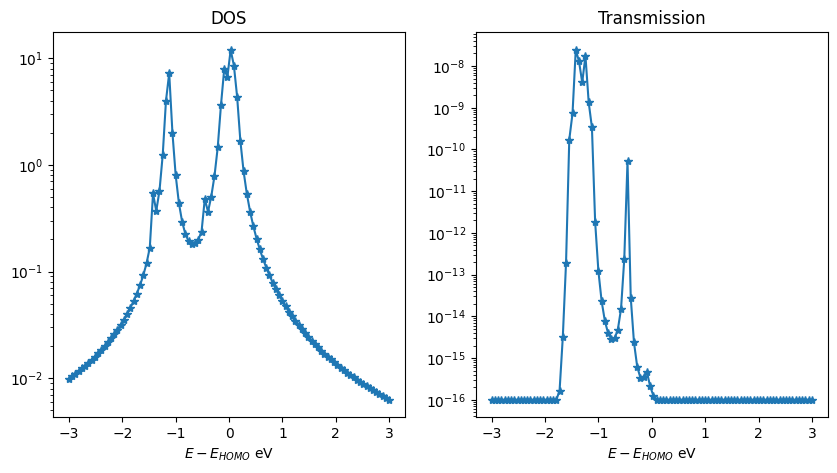

In [11]:
energy_grid=np.linspace(-3,3,100)

# Set up contacts:
gammaL = np.zeros(graph.num_dna_nodes)
gammaL[lCont] = contVal
gammaR = np.zeros(graph.num_dna_nodes)
gammaR[rCont] = contVal

#Get DOS/Transmission
T, dos = getTransmissionDOS(sequence, complement, energy_grid, gammaL, gammaR)
fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, dos, '*-')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.semilogy(energy_grid, T, '*-')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')

# Part 2: Using Pre-trained Model
Let's use our already generated model to see how well it works:

Loading model from: ./trained_models/standard_2000x_4to10BP_1000epoch.pth
Using device: cpu
Detected DNATransportGNN model
DNATransportGNN initialized successfully
Model loaded successfully!
Model parameters: 1,411,272
Energy grid: 100 points from -3.00 to 3.00 eV
Predicting for sequence: GGTATTTTACGC
                         __ATAAAATG__
Left contact at position [0, 1], coupling: 0.1
Right contact at position [10, 11], coupling: 0.1
Prediction completed!
DOS range: [-16.1374, -6.9398]
Transmission range: [-2.5379, 1.1972]


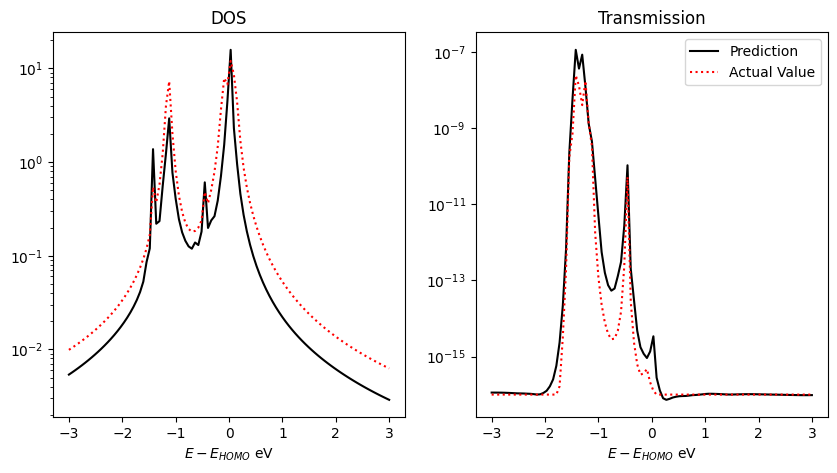

In [12]:
# Or import and use
from models import load_trained_model, predict_sequence

# Load model
model, energy_grid, device = load_trained_model("./trained_models/standard_2000x_4to10BP_1000epoch.pth")

# Predict single sequence
trans_pred, dos_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont, 
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, 10**dos_pred, '-k', energy_grid, dos, ':r')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])
ax2.semilogy(energy_grid, 10**trans_pred, '-k', energy_grid, T, ':r')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])

Loading model from: ./trained_models/hamiltonian_2000x_4to10BP_1000epoch.pth
Using device: cpu
Detected DNATransportHamiltonianGNN model
DNATransportHamiltonianGNN initialized successfully
Model loaded successfully!
Model parameters: 599,298
Energy grid: 100 points from -3.00 to 3.00 eV
Predicting for sequence: GGTATTTTACGC
                         __ATAAAATG__
Left contact at position [0, 1], coupling: 0.1
Right contact at position [10, 11], coupling: 0.1
Prediction completed!
DOS range: [-16.0000, -8.6523]
Transmission range: [-2.1822, 1.1012]


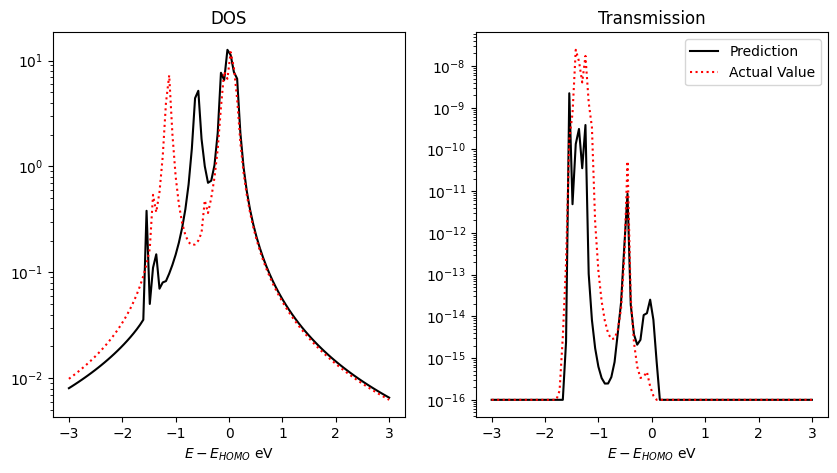

In [13]:
# Or import and use
from models import load_trained_model, predict_sequence

# Load model
model, energy_grid, device = load_trained_model("./trained_models/hamiltonian_2000x_4to10BP_1000epoch.pth")

# Predict single sequence
trans_pred, dos_pred = predict_sequence(
    model, 
    sequence, 
    complement,
    left_contact_positions=lCont,
    right_contact_positions=rCont, 
    left_contact_coupling=contVal,
    right_contact_coupling=contVal
)

fix, (ax1, ax2)= plt.subplots(1,2, figsize=(10,5))
ax1.semilogy(energy_grid, 10**dos_pred, '-k', energy_grid, dos, ':r')
ax1.set_title('DOS')
ax1.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])
ax2.semilogy(energy_grid, 10**trans_pred, '-k', energy_grid, T, ':r')
ax2.set_title('Transmission')
ax2.set_xlabel(r'$E-E_{HOMO}$ eV')
ax2.legend(['Prediction', 'Actual Value'])

C:\Users\trollium\AppData\Local\Temp\ipykernel_15784\4109945115.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.matshow(np.abs(model.H[0]))


([<matplotlib.axis.XTick at 0x2920959c690>,
 [Text(0, 1, 'G'),
  Text(1, 1, 'G'),
  Text(2, 1, 'T'),
  Text(3, 1, 'A'),
  Text(4, 1, 'T'),
  Text(5, 1, 'T'),
  Text(6, 1, 'T'),
  Text(7, 1, 'T'),
  Text(8, 1, 'A'),
  Text(9, 1, 'C'),
  Text(10, 1, 'G'),
  Text(11, 1, 'C'),
  Text(12, 1, 'A'),
  Text(13, 1, 'T'),
  Text(14, 1, 'A'),
  Text(15, 1, 'A'),
  Text(16, 1, 'A'),
  Text(17, 1, 'A'),
  Text(18, 1, 'T'),
  Text(19, 1, 'G')])

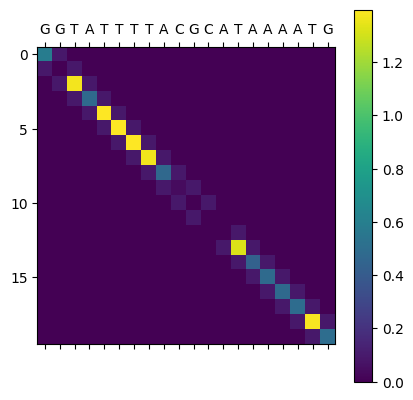

In [44]:
plt.matshow(np.abs(model.H[0]))
plt.colorbar()
strand = sequence+complement.replace('_', '')[::-1]
plt.xticks(np.arange(len(strand)), strand)

In [53]:
for ch in 'GCTA':
    print(ch, ':', strand.count(ch))

G : 4
C : 2
T : 7
A : 7


In [50]:
torch.sort(torch.diag(model.H[0])).values

tensor([-1.3977, -1.3974, -1.3965, -1.3826, -1.3753, -1.3657, -1.3237, -0.5876,
        -0.5005, -0.4931, -0.4849, -0.4839, -0.4753, -0.4732, -0.4321, -0.0405,
         0.0022,  0.0022,  0.0022,  0.0022])